<a href="https://colab.research.google.com/github/mrutherfoord/portfolio/blob/master/Cats_vs_Dogs_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs. Dog Convolutional Neural Net

For this project I used 4 covnets to try to accurately predict whether an image is a cat or a dog. I chose to use 2000 images (1000 cat and 1000 dog) from the dataset. When split into an 80/20 train/test, I was left with 1600 images to train on with 400 used for testing.

I utilized Keras for all models.

# Data Loading and Preprocessing for Models 1 & 2


In [0]:
# Initial deep neural network set-up from 
# Géron, A. 2017. Hands-On Machine Learning with Scikit-Learn 
#    & TensorFlow: Concepts, Tools, and Techniques to Build 
#    Intelligent Systems. Sebastopol, Calif.: O'Reilly. 
#    [ISBN-13 978-1-491-96229-9] 
#    Source code available at https://github.com/ageron/handson-ml
#    See file 10_introduction_to_artificial_neural_networks.ipynb 
#    Revised from MNIST to Cats and Dogs to begin Assignment 7
#    #CatsDogs# comment lines show additions/revisions for Cats and Dogs

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common modules
import os 
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
from IPython.display import display 
import PIL

#data preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

# Modules for neural nets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import BatchNormalization

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
from time import time

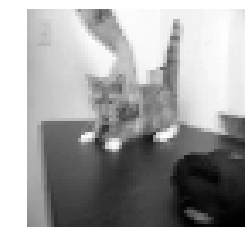

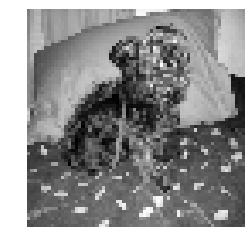

In [0]:
# Cats and dogs image height and width
height = 64
width = 64   
    
# Loading .npy files as instructed 
cats_1000_64_64_1 = np.load('cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats_dogs_64-128/dogs_1000_64_64_1.npy')

# Display of first cat and dog image
from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

In [0]:
# These numpy arrays were generated in previous data prep work
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

# Min Max Scaling
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max = scaler.transform(X_cat_dog)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = 42)

In [0]:
# Reshaping data 
X_cat_dog_min_max = X_cat_dog_min_max.reshape(-1,64,64,1)
X_train = X_train.reshape(-1,64,64,1)
X_test = X_test.reshape(-1,64,64,1)

# Model 1

I thought I would start out with a simple model to set a baseline for myself. This model has 2 convolutional layers with 32 filters a piece, then flattens to a single dense layer containing 100 neurons and a dropout rate of .5. I also decided on 35 epochs 

In [0]:
# Running a first time without cross-validation to get a general idea of model perfomance (for time-saving purposes)
# Setting optimizer
optimizer = RMSprop(lr=.0001)
model = Sequential()

# Adding Layers
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Model compiling
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               819300    
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
__________

In [0]:
%%time
# Fitting model and creating validation set to plot learning curve
history = model.fit(X_train, y_train, epochs=35, validation_split=.2, shuffle=True, verbose=0)

Wall time: 7min 6s


In [0]:
#Evaluate test set
model.evaluate(X_test, y_test)

400/400 [==============================] - 1s 3ms/step


[0.6087833857536316, 0.6525]

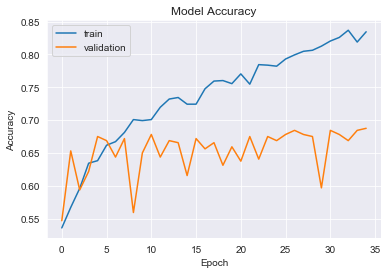

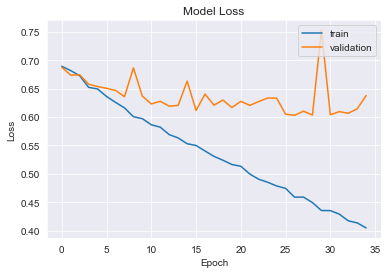

In [0]:
sns.set_style('darkgrid')

#  Accuracy Plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

This model's accuracy seems to stop improving at around 68% somewhere between 12 and 20 epochs. After that the model begins to severly overfit. Using cross-validation with 15 epochs gives an good idea of this model's general accuracy.

In [0]:
%%time
# Setting up cross-validation with 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train, test in kfold.split(X_cat_dog_min_max, y_cat_dog):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_cat_dog_min_max[train], y_cat_dog[train], epochs=15, batch_size=10, verbose=0)
    
    # evaluate the model
    scores = model.evaluate(X_cat_dog_min_max[test], y_cat_dog[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 68.25%
68.25% (+/- 0.00%)
acc: 67.25%
67.75% (+/- 0.50%)
acc: 68.75%
68.08% (+/- 0.62%)
acc: 68.25%
68.12% (+/- 0.54%)
acc: 70.75%
68.65% (+/- 1.16%)
Wall time: 21min 5s


# Model 2
For Model 2, I wanted to experiment with adding more layers, while increasing the amount filters as the model moves toward the output.   

In [0]:
# Model 2
model2 = Sequential()

model2.add(Conv2D(16, (3, 3), padding='valid', input_shape=(64,64,1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 14, 14, 64)        36928     
__________

In [0]:
%%time
history2 = model2.fit(X_train, y_train, epochs=35, validation_split=.1, shuffle=True, verbose=0)

Wall time: 9min 30s


In [0]:
#Evaluate test set
model2.evaluate(X_test, y_test)

400/400 [==============================] - 1s 4ms/step


[0.6550853371620178, 0.6675]

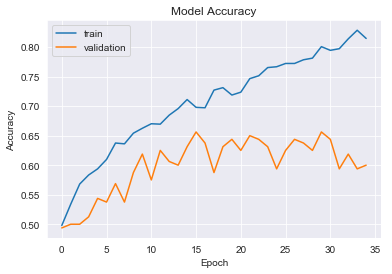

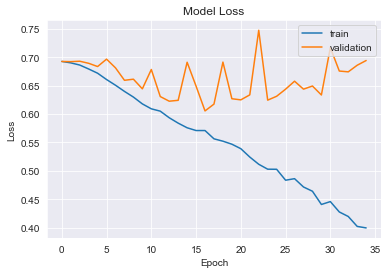

In [0]:
#  Accuracy Plot
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss Plot
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

In [0]:
%%time
cvscores = []
for train, test in kfold.split(X_cat_dog_min_max, y_cat_dog):
    model2 = Sequential()

    model2.add(Conv2D(16, (3, 3), padding='valid', input_shape=(64,64,1), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Flatten())

    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Fit the model
    model2.fit(X_cat_dog_min_max[train], y_cat_dog[train], epochs=15, batch_size=10, verbose=0)
    
    # evaluate the model
    scores = model2.evaluate(X_cat_dog_min_max[test], y_cat_dog[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 65.50%
68.12% (+/- 1.58%)
acc: 65.25%
67.71% (+/- 1.77%)
acc: 65.50%
67.44% (+/- 1.81%)
acc: 65.00%
67.17% (+/- 1.87%)
acc: 71.00%
67.55% (+/- 2.12%)
Wall time: 24min 54s


The scores are pretty consistent againt the cross-validation, but since stacking more convolution layers doesn't seem to be helping, I thought I would again try a simpler model that utilizes image augmentation to see if I can get a better score. Training too few images may be leading to a relatively low accuracy.

# Model 3
In Model 3, I went back to using less layers, with only one convolutional layer per pooling layer, but I used image augmentation to help with training. I also chose more epochs with this method.

In [0]:
# Model 3
model3 = Sequential()

model3.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', data_format="channels_last", activation='relu', 
                  use_bias=True,
                  input_shape=(64,64,3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
# Image Augmentation
# Dimensions of the images.
img_width, img_height = 64, 64

train_data_dir = 'data/train'
test_data_dir = 'data/test'
nb_train_samples = 1600
nb_validation_samples = 400
epochs = 50
batch_size = 20

# Augmentation parameters for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generator that will read pictures found in subfolers of 'data/train', and generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

# Generator for validation data
validation_generator = test_datagen.flow_from_directory(test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [0]:
if ks.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
%%time
history3 = model3.fit_generator(train_generator,
                                steps_per_epoch=nb_train_samples // batch_size,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=nb_validation_samples // batch_size, verbose=0)

model3.save_weights('model3.h5')

Wall time: 23min 37s


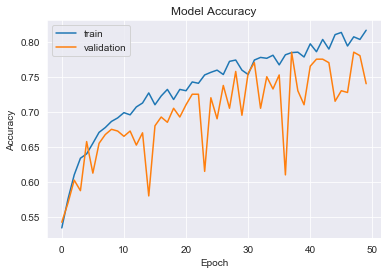

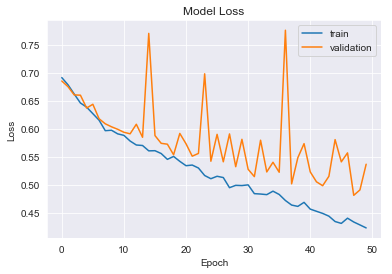

In [0]:
# Accuracy Plot
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss Plot
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

It took a little longer, but this model's performance is much better. Unfortunately I couldn't figure out how to do cross validation using ImageDataGenerator, but I did run the model 3 separate time with simialr results (close to 80% accuracy at 50 epochs). I am also unsure about handling scaling using this method since no examples I found prescaled the images. This seems like a good idea for smaller training sets, though.

I continued the training further to see if the accuracy would improve anymore, but found that 80% was about the best I could get.

In [0]:
%%time
history4 = model3.fit_generator(train_generator,
                                steps_per_epoch=nb_train_samples // batch_size,
                                epochs=70,
                                validation_data=validation_generator,
                                validation_steps=nb_validation_samples // batch_size, verbose=0)

model3.save_weights('model3a.h5')

Wall time: 24min 57s


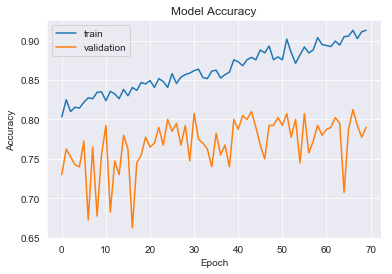

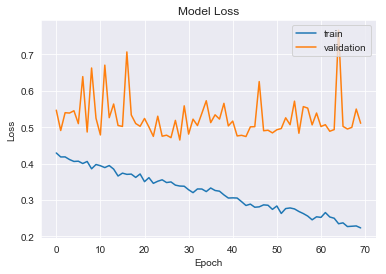

In [0]:
# Accuracy Plot
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss Plot
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Model 4

For my last model, I thought I would try using batch normalization layers with the original greyscale training set.

In [0]:
optimizer = RMSprop(lr=.01)
#Model 4
model4 = Sequential()

model4.add(Conv2D(32, (5, 5), strides=(1, 1), padding="valid", data_format="channels_last", activation='relu', 
      use_bias=False,
      input_shape=(64,64,1)))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (3, 3), use_bias=False, padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(256, (3, 3), use_bias=False, padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())

model4.add(Dense(128, activation='relu', use_bias=False))
model4.add(Dropout(0.5))

model4.add(Dense(64, activation='relu', use_bias=False))
model4.add(Dropout(0.5))

model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 60, 60, 32)        800       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 30, 30, 128)       36864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 15, 15, 256)       294912    
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 256)       1024      
__________

In [0]:
%%time
history5 = model4.fit(X_train, y_train, epochs=35, validation_split=.2, shuffle=True, verbose=0)

Wall time: 35min 13s


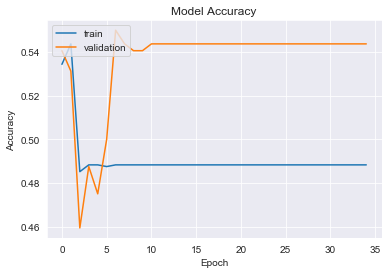

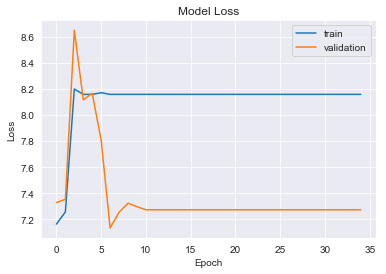

In [0]:
# Accuracy Plot
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

I thought I would be able to increase the learning rate because of the Batch Normalization, but I increased it way too much. I next tried a cross-validated version with a slower learning rate and less epochs.

In [0]:
%%time
optimizer = RMSprop(lr=.001)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X_cat_dog_min_max, y_cat_dog):
    model4 = Sequential()

    model4.add(Conv2D(32, (5, 5), strides=(1, 1), padding="valid", data_format="channels_last", activation='relu', 
          use_bias=False,
          input_shape=(64,64,1)))
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Conv2D(128, (3, 3), use_bias=False, padding='same', activation='relu'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Conv2D(256, (3, 3), use_bias=False, padding='same', activation='relu'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Flatten())

    model4.add(Dense(128, activation='relu', use_bias=False))
    model4.add(Dropout(0.5))

    model4.add(Dense(64, activation='relu', use_bias=False))
    model4.add(Dropout(0.5))

    model4.add(Dense(1, activation='sigmoid'))

    model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Fit the model
    model4.fit(X_cat_dog_min_max[train], y_cat_dog[train], epochs=5, batch_size=15, verbose=0)
    
    # evaluate the model
    scores = model4.evaluate(X_cat_dog_min_max[test], y_cat_dog[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    

acc: 50.00%
50.00% (+/- 0.00%)
acc: 50.75%
50.38% (+/- 0.37%)
acc: 50.00%
50.25% (+/- 0.35%)
acc: 49.75%
50.12% (+/- 0.37%)
acc: 52.50%
50.60% (+/- 1.01%)
Wall time: 28min 50s


That did not work at all. I would have to investigate batch normalization a little more before I try it again.

# Conclusion

While time consuming to test and run models, The Covnet seems like it would be very useful to a company who wants a high-accuracy image classifier. My personal computer's limitations prevented me from using more images, but I feel confident that a larger data set would have yielded better results. I also feel like having the time/ability to use RandomSearch would help tune the myriad of hyperparameters.

Another option for this company would be to use a pretrained Covnet. There are a number of convolutional neural nets that have already been trained on hundreds of images including cats and dogs. Tuning of covnet like that could save a lot of time and possibly have better accuracy.